In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.integrate import solve_ivp
from scipy import sparse
from scipy.integrate import solve_bvp
from matplotlib.pyplot import figure
%matplotlib inline

import matplotlib.animation as animation
K = 100*10**9/1.76

# Equations to Model

Tumors $\rightarrow$ Mass? or Num of cells

Breast cancer Gompertz model  $\rightarrow \frac{dT}{dt} = k_g*T*ln(\frac{T_{max}}{T})$

Create two functions:

1. Gompertz Model
2. Add a Treatment Function
3. doubles every 180 days

Tmax = $\frac{100\cdot10^{9}}{1.76}$

## Homogenous Breast Cancer growth

In [2]:
def GompertzFE(t,x0=1,k=1/90,Tmax=K):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T)
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden (rounded to the nearest integer)
        x0 (float): The initial condition
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    # Calculate U 
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j])
    return T

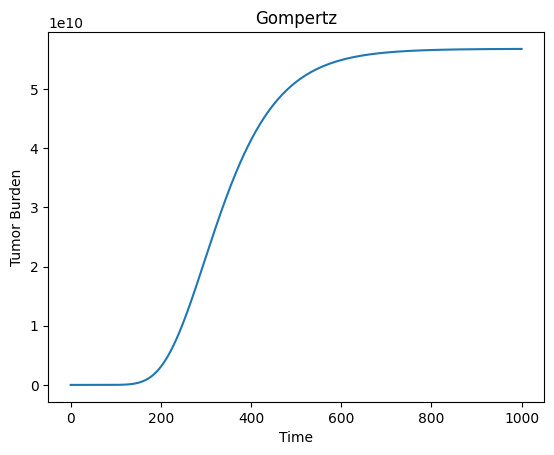

<Figure size 640x480 with 0 Axes>

In [3]:
x0 = 1
k = 1/90 # ?? doubles every 180 days, find the rate
t = np.linspace(0,1000,1300)
T = GompertzFE(t)
plt.plot(t,T)
plt.title('Gompertz')
plt.xlabel('Time')
plt.ylabel('Tumor Burden')
plt.show()
plt.savefig("Gompertz.png")

## Breast Cancer Treatment

In [6]:
def GompertzFEfunction(t,f,x0=1,k=1/90,Tmax=K):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T) + f
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        f (callable): The nonhomogenous portion (treatment term)
        x0 (float): The initial condition
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden 
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    # Calculate U 
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j]) + ht*f(T[j])
    return T

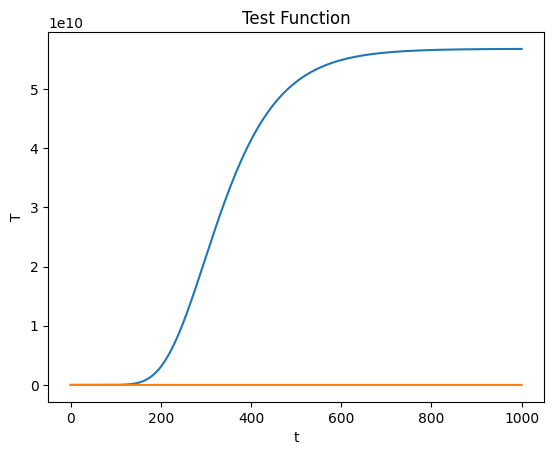

In [6]:
x0 = 1
k = .5
t = np.linspace(0,1000,1300)
Tmax = 100000
f = lambda x: -x
Thom = GompertzFE(t)
T = GompertzFEfunction(t, f)
plt.plot(t,Thom)
plt.plot(t,T)
plt.title('Test Function')
plt.xlabel('t')
plt.ylabel('T')
plt.show()

In [4]:
def GompertzFEchemo(t,x0=1,k=1/90,Tmax=K,mu=.9,gamma=0.92, tc=60):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T) + mu*c(t)*T
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        x0 (float): The initial condition
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden 
        mu (float): fraction of tumor cells killed ~ .9
        gamma (float): drug decay rate ~ ln(2)/halflife
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    c = lambda x: np.exp(-gamma * x) # Model drug concentration
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    t1, t2 = t[t < tc], t[t >= tc]
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[:len(t1)] = GompertzFE(t1,x0,k,Tmax)
    # Calculate U 
    for j in range(len(t1)-1,len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j]) - ht*mu*c(ht*(j - (len(t1)-1)))*T[j]
        if T[j+1] == 0:
            return T
    return T

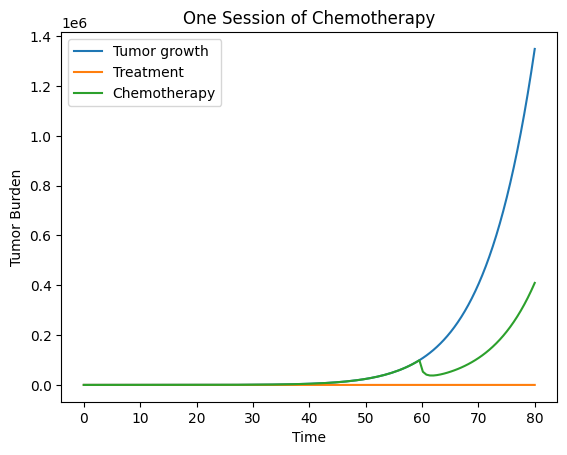

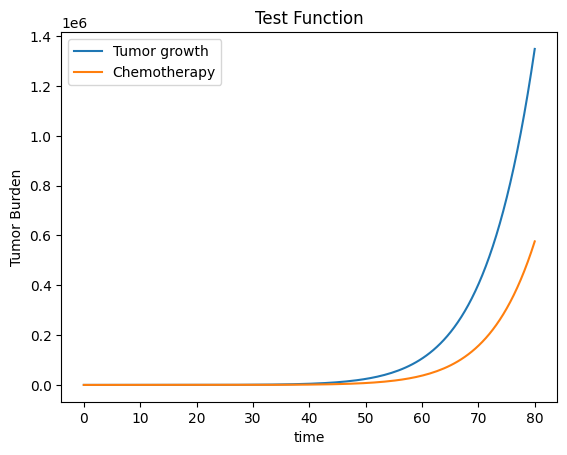

In [7]:
t = np.linspace(0,80,130)
f = lambda x: -x
Thom = GompertzFE(t)
Tnon = GompertzFEfunction(t,f)
Tche = GompertzFEchemo(t)
plt.plot(t,Thom, label='Tumor growth')
plt.plot(t,Tnon, label='Treatment')
plt.plot(t,Tche, label='Chemotherapy')
plt.title('One Session of Chemotherapy')
plt.xlabel('Time')
plt.ylabel('Tumor Burden')
plt.legend()
plt.show()
plt.savefig("Gompertz1Chemo.png")
Thom = GompertzFE(t)
Tche = GompertzFEchemo(t, tc=30)
plt.plot(t,Thom, label='Tumor growth')
plt.plot(t,Tche, label='Chemotherapy')
plt.title('Test Function')
plt.xlabel('time')
plt.ylabel('Tumor Burden')
plt.legend()
plt.show()

In [8]:
def treatment_plan(t_stop=270,t_freq=14,num_t=14,x0=1,k=1/90,Tmax=K,mu=.9,gamma=0.92,tc=60):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T) + sum(mu*c_n(t)*T) for different c_n terms 
    
    using the Forward Euler method. 
    Parameters:
        t_stop (int): Maximum days of treatment
        t_freq (int): Days between treatments
        num_t (int): Number of treatments
        x0 (float): The initial condition
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden 
        mu (float): fraction of tumor cells killed ~ .9
        gamma (float): drug decay rate ~ ln(2)/halflife
        tc (int): day treatment starts
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    c = lambda x: np.exp(-gamma * x) # Model drug concentration
    t = np.linspace(0,t_stop,3*t_stop)
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    #Calculate T
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j])
        for i in range(num_t):
            if t[j] >= tc + i*t_freq:
                T[j+1] -= ht*mu*c(ht*(t[j] - (tc + i*t_freq)))*T[j]
        if T[j+1] <= 0 and t[j] >= tc: #Can change 0 to something else if you want
            return t, T
    return t, T

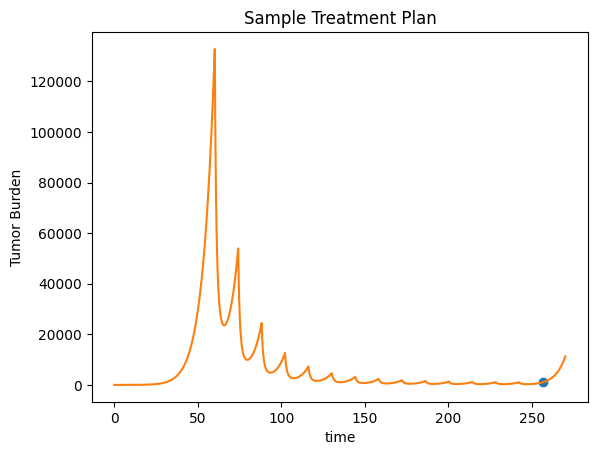

<Figure size 640x480 with 0 Axes>

In [9]:
t, T = treatment_plan()
plt.plot(t,T, 'o', markevery=[768])
plt.plot(t,T)
plt.title('Sample Treatment Plan')
plt.xlabel('time')
plt.ylabel('Tumor Burden')
plt.show()
plt.savefig("ChemoTreatment.png")

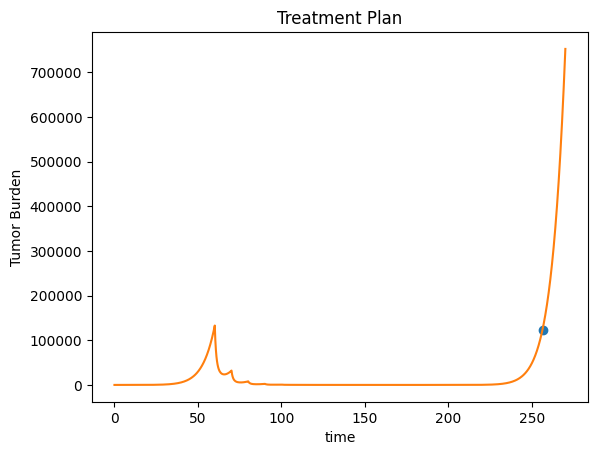

In [11]:
t, T = treatment_plan(t_freq=10)
plt.plot(t,T, 'o', markevery=[768])
plt.plot(t,T)
plt.title('Treatment Plan')
plt.xlabel('time')
plt.ylabel('Tumor Burden')
plt.show()

In [10]:
def forward_Euler(t,f,x0=1):
    """ Numerically approximates the x value from IVP: 
    
    T' = f(T)
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        f (callable): The function being approximated
        x0 (float): The initial condition
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    # Calculate U 
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*f(T[j])
    return T

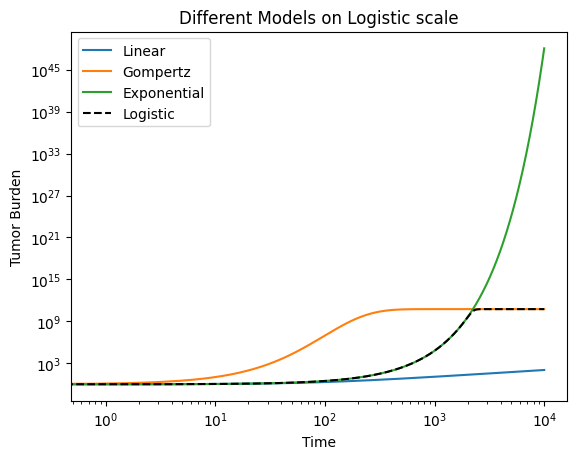

<Figure size 640x480 with 0 Axes>

In [11]:
t, k = np.linspace(0,10000,13000), 1/90
fLin = lambda x: k
fExp = lambda x: k*x
fLog = lambda x: k*x*(1-x/K)

sLin = forward_Euler(t,fLin)
sExp = forward_Euler(t,fExp)
sLog = forward_Euler(t,fLog)
sGom = GompertzFE(t)

plt.loglog(t, sLin, label='Linear')
plt.loglog(t, sGom, label='Gompertz')
plt.loglog(t, sExp, label='Exponential')
plt.loglog(t, sLog,'--k', label='Logistic')
plt.title('Different Models on Logistic scale')
plt.xlabel('Time')
plt.ylabel('Tumor Burden')
plt.legend()
plt.show()
plt.savefig("Different_Models_Forward_Euler.png")